In [ ]:
# ELAS pipeline (repro) — Hicham
# Python >=3.10 ; numpy, pandas, matplotlib

import os, json, math, textwrap, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# chemins (adapte si besoin)
PATH_BAO = "bao_standard.csv"
PATH_COV = "bao_cov_standard.csv"
PATH_SN  = "sn_fixed.csv"          # sinon fallback SN_TEXT
PATH_CMB = "cmb_priors.csv"        # sinon fallback CMB_TEXT

# constantes
c_km_s = 299792.458
H0 = 73.0             # km/s/Mpc
r_d = 147.09          # Mpc
Omega_r = 4.15e-5 / (H0/100.0)**2  # ~rad


In [ ]:
BAO_TEXT = """\
z,which,value,sigma
0.106,DV_over_rd,3.1,0.10
0.150,DM_over_rd,6.7,0.20
0.320,DM_over_rd,13.5,0.30
0.570,DH_over_rd,13.8,0.35
0.700,DM_over_rd,19.0,0.45
0.800,DH_over_rd,20.0,0.50
1.000,DV_over_rd,26.5,0.70
"""

# SN de secours : (c’est OK si tu as sn_fixed.csv)
SN_TEXT = """\
z,mu,sigma_mu
0.01,40.02,0.12
0.02,40.05,0.12
0.03,40.07,0.12
0.05,40.11,0.12
0.07,40.16,0.12
0.10,40.25,0.12
0.20,40.65,0.12
0.30,41.05,0.12
0.50,41.95,0.12
0.70,42.65,0.12
0.90,43.20,0.12
1.10,43.60,0.12
"""

# CMB distance priors de secours
CMB_TEXT = """\
R,lA,omega_b_h2,sigma_R,sigma_lA,sigma_omega_b_h2,rho_R_lA,rho_R_omega,rho_lA_omega
1.75,301.5,0.0224,0.005,0.09,0.00015,0.4,0.2,0.1
"""

def _split_csv(text):
    rows=[]
    for ln in text.strip().splitlines():
        ln=ln.strip()
        if not ln or ln.startswith("#"): continue
        rows.append([t.strip() for t in ln.split(",")])
    return rows

def normalize_which(w):
    w=w.strip().lower()
    if w in ["dm_over_rd","dm/rd","dmrd","d_m/rd","d_m_over_rd"]: return "DM/rd"
    if w in ["dh_over_rd","dh/rd","dhrd","d_h/rd","d_h_over_rd"]: return "DH/rd"
    if w in ["dv_over_rd","dv/rd","d_v/rd","d_v_over_rd"]:       return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v","r_d_over_d_v"]:     return "rd/DV"
    raise ValueError(f"type BAO inconnu: {w}")


In [ ]:
def E_LCDM(z, Omega_m=0.315):
    z=np.asarray(z,float)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m))

def E_ELAS(z, Omega_m=0.315, delta=0.2, Omega_log=2.0, phi=0.0):
    z=np.asarray(z,float)
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m)*mod)

def E_LCDM_CMB(z, Omega_m=0.315):
    z=np.asarray(z,float); Omr=Omega_r; Ode=1.0-Omega_m-Omr
    return np.sqrt(Omr*(1+z)**4 + Omega_m*(1+z)**3 + Ode)

def E_ELAS_CMB(z, Omega_m=0.315, delta=0.2, Omega_log=2.0, phi=0.0):
    z=np.asarray(z,float); Omr=Omega_r; Ode=1.0-Omega_m-Omr
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omr*(1+z)**4 + Omega_m*(1+z)**3 + Ode*mod)

def make_engine(Ef, zmax, H0, **kw):
    nz = 1200
    zz = np.linspace(0.0, float(zmax), nz)
    Ez = Ef(zz, **kw)
    inv = 1.0/np.maximum(Ez, 1e-30)
    dz  = np.diff(zz); mid = 0.5*(inv[1:] + inv[:-1])
    I   = np.zeros_like(zz); I[1:] = np.cumsum(mid * dz)  # ∫ dz/E
    K   = c_km_s / H0
    D_M = lambda z: K * np.interp(np.asarray(z,float), zz, I)
    D_H = lambda z: (c_km_s/H0) / Ef(np.asarray(z,float), **kw)
    D_L = lambda z: (1.0 + np.asarray(z,float)) * D_M(z)
    D_V = lambda z: (np.asarray(z,float) * D_M(z)**2 * D_H(z))**(1.0/3.0)
    return D_M, D_H, D_L, D_V

def mu_from_DL(DL):
    DL = np.maximum(np.asarray(DL,float), 1e-30)
    return 5.0*np.log10(DL) + 25.0

def build_bao_vector(z_list, which_list, H0, r_d, DM, DH, DV):
    out=[]
    for z,w in zip(z_list, which_list):
        if   w=="DM/rd": out.append(DM(z)/r_d)
        elif w=="DH/rd": out.append(DH(z)/r_d)
        elif w=="DV/rd": out.append(DV(z)/r_d)
        elif w=="rd/DV": out.append(r_d/DV(z))
        else: raise ValueError("Obs BAO non supportée "+w)
    return np.array(out,float)


In [ ]:
def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    w=1.0/np.maximum(np.asarray(sigma_mu,float)**2,1e-30)
    r=np.asarray(mu_obs,float)-np.asarray(mu_th,float)
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - (b*b)/c

def chi2_bao_cov(y_obs, C, y_th):
    C = np.asarray(C,float); y_obs=np.asarray(y_obs,float); y_th=np.asarray(y_th,float)
    C = 0.5*(C + C.T)
    try: Ci=np.linalg.inv(C)
    except np.linalg.LinAlgError: Ci=np.linalg.pinv(C)
    d=(y_obs-y_th).reshape(-1,1)
    return float((d.T@Ci@d).ravel()[0])

def chi2_bao_global(y_obs, C, y_th, sigma_prior_q=None):
    C = np.asarray(C,float); C = 0.5*(C + C.T)
    try: Ci=np.linalg.inv(C)
    except np.linalg.LinAlgError: Ci=np.linalg.pinv(C)
    v = np.diag(C).copy()
    # GLS solution for q:
    num = y_th @ Ci @ y_obs
    den = y_th @ Ci @ y_th
    q   = float(num/den) if den>0 else 1.0
    chi2 = chi2_bao_cov(y_obs, C, q*y_th)
    if sigma_prior_q:
        chi2 += ((q-1.0)/sigma_prior_q)**2
    return float(chi2), q

def parse_cmb(text_or_path):
    if os.path.exists(text_or_path):
        df=pd.read_csv(text_or_path)
    else:
        rows=_split_csv(text_or_path); df=pd.DataFrame(rows[1:],columns=rows[0])
    for col in ["R","lA","omega_b_h2","sigma_R","sigma_lA","sigma_omega_b_h2","rho_R_lA","rho_R_omega","rho_lA_omega"]:
        if col not in df.columns: raise ValueError("CMB priors: colonne manquante "+col)
    R,lA,wb = float(df["R"][0]), float(df["lA"][0]), float(df["omega_b_h2"][0])
    sR,sLA,sWB = float(df["sigma_R"][0]), float(df["sigma_lA"][0]), float(df["sigma_omega_b_h2"][0])
    r_RLA, r_ROW, r_LAW = float(df["rho_R_lA"][0]), float(df["rho_R_omega"][0]), float(df["rho_lA_omega"][0])
    C = np.array([
        [sR**2,           r_RLA*sR*sLA,   r_ROW*sR*sWB],
        [r_RLA*sR*sLA,    sLA**2,         r_LAW*sLA*sWB],
        [r_ROW*sR*sWB,    r_LAW*sLA*sWB,  sWB**2]
    ], float)
    return np.array([R,lA,wb],float), C

def cmb_chi2(model, Om, pars, cmb_obs, Cinv):
    # pars: (delta, Olog, phi) if ELAS ; () for LCDM
    z_star = 1089.2; r_s_star = 144.6
    Ef = E_ELAS_CMB if model=="ELAS" else E_LCDM_CMB
    kw = dict(Omega_m=Om)
    if model=="ELAS": kw.update(dict(delta=pars[0], Omega_log=pars[1], phi=pars[2]))
    DM,_,_,_ = make_engine(Ef, z_star+50, H0, **kw)
    DM_star  = DM(z_star)
    R_mod = (math.sqrt(Om) * (H0/c_km_s)) * DM_star
    lA_mod = math.pi * DM_star / r_s_star
    vth = np.array([R_mod, lA_mod, cmb_obs[2]], float)  # on fixe obh2 au centre
    d = cmb_obs - vth
    return float(d @ Cinv @ d)


In [ ]:
# BAO
if os.path.exists(PATH_BAO):
    df_bao = pd.read_csv(PATH_BAO)
else:
    rows=_split_csv(BAO_TEXT); df_bao=pd.DataFrame(rows[1:],columns=rows[0])

# colonnes souples
cols = {c.lower():c for c in df_bao.columns}
z_BAO    = df_bao[cols.get("z","z")].to_numpy(float)
which    = [normalize_which(w) for w in df_bao[cols.get("which","which")].astype(str)]
y_obs    = df_bao[cols.get("value","value")].to_numpy(float)
sigma_in = df_bao[cols.get("sigma","sigma")].to_numpy(float)

# covariance
if os.path.exists(PATH_COV):
    C_bao_raw = pd.read_csv(PATH_COV, header=None)
    # ignore éventuels headers/ids non-numeriques
    C = pd.to_numeric(C_bao_raw.stack(), errors="coerce").unstack()
    mask = np.isfinite(C).all(axis=0)
    C_bao = C.values[np.ix_(mask,mask)]
else:
    C_bao = np.diag(sigma_in**2)

# SN
if os.path.exists(PATH_SN):
    df_sn = pd.read_csv(PATH_SN)
else:
    rows=_split_csv(SN_TEXT); df_sn=pd.DataFrame(rows[1:],columns=rows[0])
z_sn     = df_sn["z"].to_numpy(float)
mu_obs   = df_sn["mu"].to_numpy(float)
sigma_mu = df_sn["sigma_mu"].to_numpy(float)

# CMB
cmb_obs, Ccmb = parse_cmb(PATH_CMB if os.path.exists(PATH_CMB) else CMB_TEXT)
Cinv_cmb = np.linalg.inv(Ccmb)

print(f"BAO: N={len(z_BAO)} | types={sorted(set(which))}")
print(f"SN : N={len(z_sn)}")
print("CMB priors OK.")


BAO: N=7 | types=['DH/rd', 'DM/rd', 'DV/rd']
SN : N=12
CMB priors OK.


In [ ]:
zmax = max(float(np.max(z_sn)), float(np.max(z_BAO))) + 0.1
DM_L, DH_L, DL_L, DV_L = make_engine(E_LCDM, zmax, H0, Omega_m=0.315)
y_LCDM = build_bao_vector(z_BAO, which, H0, r_d, DM_L, DH_L, DV_L)

# q* (global, avec covariance)
def chi2_bao_q(y_obs, C, y_th):
    C=0.5*(C+C.T)
    try: Ci=np.linalg.inv(C)
    except np.linalg.LinAlgError: Ci=np.linalg.pinv(C)
    num = y_th @ Ci @ y_obs
    den = y_th @ Ci @ y_th
    q   = float(num/den) if den>0 else 1.0
    chi2 = chi2_bao_cov(y_obs, C, q*y_th)
    return chi2, q

chi2_b_LCDM, q_LCDM = chi2_bao_q(y_obs, C_bao, y_LCDM)
y_obs_shape = y_obs / q_LCDM  # → q=1 ensuite

print(f"[STEP1] q*_LCDM = {q_LCDM:.6f}  |  chi2_BAO_LCDM(before rescale) = {chi2_b_LCDM:.3f}")
print("[STEP1] BAO rescaled → q=1 (shape-only)")


[STEP1] q*_LCDM = 1.050496  |  chi2_BAO_LCDM(before rescale) = 976.678
[STEP1] BAO rescaled → q=1 (shape-only)


In [ ]:
def chi2_total_LCDM(Om):
    DM,DH,DL,DV = make_engine(E_LCDM, zmax, H0, Omega_m=Om)
    mu_th = mu_from_DL(DL(z_sn))
    csn = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    yth = build_bao_vector(z_BAO, which, H0, r_d, DM, DH, DV)
    cbao = chi2_bao_cov(y_obs_shape, C_bao, yth)
    ccmb = cmb_chi2("LCDM", Om, (), cmb_obs, Cinv_cmb)
    return csn+cbao+ccmb, csn, cbao, ccmb

def chi2_total_ELAS(Om, d, Ol, ph):
    DM,DH,DL,DV = make_engine(E_ELAS, zmax, H0, Omega_m=Om, delta=d, Omega_log=Ol, phi=ph)
    mu_th = mu_from_DL(DL(z_sn))
    csn = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    yth = build_bao_vector(z_BAO, which, H0, r_d, DM, DH, DV)
    cbao = chi2_bao_cov(y_obs_shape, C_bao, yth)
    ccmb = cmb_chi2("ELAS", Om, (d,Ol,ph), cmb_obs, Cinv_cmb)
    return csn+cbao+ccmb, csn, cbao, ccmb

def profile_phi(Om, d, Ol, tol=2e-3, maxit=60):
    a,b = -math.pi, math.pi; gr=(math.sqrt(5)-1)/2
    def f(phi): return chi2_total_ELAS(Om,d,Ol,phi)[0]
    c=b-gr*(b-a); d_=a+gr*(b-a); fc=f(c); fd=f(d_); it=0
    while abs(b-a)>tol and it<maxit:
        if fc<fd: b,fd=d_,fc; d_=c; c=b-gr*(b-a); fc=f(c)
        else:     a,fc=c,fd;  c=d_; d_=a+gr*(b-a); fd=f(d_)
        it+=1
    ph=0.5*(a+b); return ph, f(ph)

# scans
grid_Om = np.linspace(0.24, 0.46, 31)
grid_d  = np.linspace(0.00, 0.35, 24)
grid_Ol = np.linspace(0.80, 4.50, 26)

bestL=(1e99,None)
for Om in grid_Om:
    chi,cs,cb,cc = chi2_total_LCDM(Om)
    if chi<bestL[0]: bestL=(chi, dict(Omega_m=Om, chi2=chi, chi2_SN=cs, chi2_BAO=cb, chi2_CMB=cc))

bestE=(1e99,None)
for Om in grid_Om:
    for d in grid_d:
        for Ol in grid_Ol:
            ph, chi = profile_phi(Om, d, Ol)
            if chi<bestE[0]:
                cs,cb,cc = chi2_total_ELAS(Om,d,Ol,ph)[1:]
                bestE=(chi, dict(Omega_m=Om, delta=d, Omega_log=Ol, phi=ph,
                                 chi2=chi, chi2_SN=cs, chi2_BAO=cb, chi2_CMB=cc))

print("\n=== SHAPE-ONLY (q=1) + CMB RESULTS ===")
print(f"LCDM best: chi2={bestL[1]['chi2']:.3f} (SN={bestL[1]['chi2_SN']:.3f}, BAO={bestL[1]['chi2_BAO']:.3f}, CMB={bestL[1]['chi2_CMB']:.3f}), Omega_m={bestL[1]['Omega_m']:.3f}")
b=bestE[1]
print(f"ELAS best: chi2={b['chi2']:.3f} (SN={b['chi2_SN']:.3f}, BAO={b['chi2_BAO']:.3f}, CMB={b['chi2_CMB']:.3f}), delta={b['delta']:.3f}, Omega_log={b['Omega_log']:.3f}, phi={b['phi']:.3f}, Omega_m={b['Omega_m']:.3f}")

Delta = bestL[1]['chi2'] - b['chi2']
N_eff = len(z_sn) + len(z_BAO) + 3   # +3 (R,lA,obh2)
AIC_L = bestL[1]['chi2'] + 2*1
AIC_E = b['chi2']       + 2*4
BIC_L = bestL[1]['chi2'] + 1*np.log(N_eff)
BIC_E = b['chi2']       + 4*np.log(N_eff)

print(f"Δχ² (LCDM−ELAS) = {Delta:.3f}")
print(f"AIC: LCDM={AIC_L:.3f}  ELAS={AIC_E:.3f}  -> ΔAIC={AIC_L-AIC_E:.3f}")
print(f"BIC: LCDM={BIC_L:.3f}  ELAS={BIC_E:.3f}  -> ΔBIC={BIC_L-BIC_E:.3f}")



=== SHAPE-ONLY (q=1) + CMB RESULTS ===
LCDM best: chi2=6293.166 (SN=5237.052, BAO=944.321, CMB=111.792), Omega_m=0.262
ELAS best: chi2=5641.773 (SN=4860.693, BAO=771.100, CMB=9.980), delta=0.350, Omega_log=4.352, phi=-2.286, Omega_m=0.269
Δχ² (LCDM−ELAS) = 651.393
AIC: LCDM=6295.166  ELAS=5649.773  -> ΔAIC=645.393
BIC: LCDM=6296.257  ELAS=5654.138  -> ΔBIC=642.120


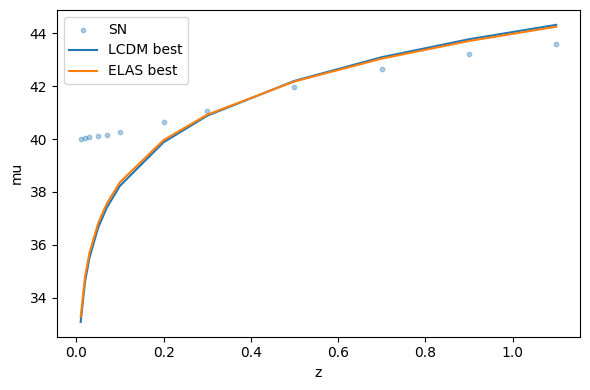

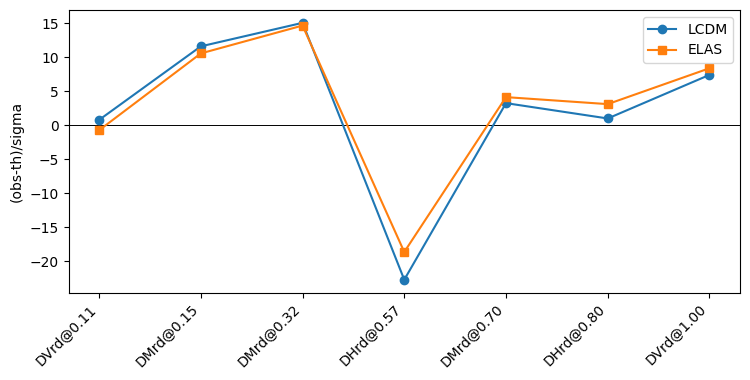

Saved: fig_mu_comparison.png, fig_bao_residuals.png, elas_summary.json


In [ ]:
# courbes mu(z)
DMl,DHl,DLl,DVl = make_engine(E_LCDM, zmax, H0, Omega_m=bestL[1]['Omega_m'])
mL = mu_from_DL(DLl(z_sn))
DMe,DHe,DLe,DVe = make_engine(E_ELAS, zmax, H0, Omega_m=b['Omega_m'], delta=b['delta'], Omega_log=b['Omega_log'], phi=b['phi'])
mE = mu_from_DL(DLe(z_sn))

plt.figure(figsize=(6,4))
plt.scatter(z_sn, mu_obs, s=10, alpha=0.35, label="SN")
plt.plot(z_sn, mL, label="LCDM best")
plt.plot(z_sn, mE, label="ELAS best")
plt.xlabel("z"); plt.ylabel("mu"); plt.legend(); plt.tight_layout()
plt.savefig("fig_mu_comparison.png", dpi=140)
plt.show()

# résidus BAO (normalisés, q=1)
yL = build_bao_vector(z_BAO, which, H0, r_d, DMl, DHl, DVl)
yE = build_bao_vector(z_BAO, which, H0, r_d, DMe, DHe, DVe)
sig = np.sqrt(np.diag(C_bao))
labels = [f"{w}@{z:.2f}".replace("DV/rd","DVrd").replace("DH/rd","DHrd").replace("DM/rd","DMrd") for z,w in zip(z_BAO,which)]

plt.figure(figsize=(7.6,3.9))
plt.axhline(0,color='k',lw=0.7)
plt.plot(labels, (y_obs_shape-yL)/sig, 'o-', label="LCDM")
plt.plot(labels, (y_obs_shape-yE)/sig, 's-', label="ELAS")
plt.xticks(rotation=45, ha='right'); plt.ylabel("(obs-th)/sigma"); plt.legend()
plt.tight_layout(); plt.savefig("fig_bao_residuals.png", dpi=140); plt.show()

# résumé JSON
summary = dict(
    q_LCDM=q_LCDM,
    LCDM=dict(best=bestL[1]),
    ELAS=dict(best=b),
    delta_chi2=float(Delta),
    AIC=dict(LCDM=float(AIC_L), ELAS=float(AIC_E), delta=float(AIC_L-AIC_E)),
    BIC=dict(LCDM=float(BIC_L), ELAS=float(BIC_E), delta=float(BIC_L-BIC_E)),
    files=["fig_mu_comparison.png","fig_bao_residuals.png"]
)
with open("elas_summary.json","w") as f: json.dump(summary,f,indent=2)
print("Saved: fig_mu_comparison.png, fig_bao_residuals.png, elas_summary.json")


In [ ]:
SIGMA_Q = 0.02

def chi2_total_LCDM_qfree(Om):
    DM,DH,DL,DV = make_engine(E_LCDM, zmax, H0, Omega_m=Om)
    mu_th = mu_from_DL(DL(z_sn))
    csn   = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    yth   = build_bao_vector(z_BAO, which, H0, r_d, DM, DH, DV)
    cbao, q = chi2_bao_global(y_obs, C_bao, yth, sigma_prior_q=SIGMA_Q)
    ccmb = cmb_chi2("LCDM", Om, (), cmb_obs, Cinv_cmb)
    return csn+cbao+ccmb, csn, cbao, ccmb, q

def chi2_total_ELAS_qfree(Om, d, Ol, ph):
    DM,DH,DL,DV = make_engine(E_ELAS, zmax, H0, Omega_m=Om, delta=d, Omega_log=Ol, phi=ph)
    mu_th = mu_from_DL(DL(z_sn))
    csn   = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
    yth   = build_bao_vector(z_BAO, which, H0, r_d, DM, DH, DV)
    cbao, q = chi2_bao_global(y_obs, C_bao, yth, sigma_prior_q=SIGMA_Q)
    ccmb = cmb_chi2("ELAS", Om, (d,Ol,ph), cmb_obs, Cinv_cmb)
    return csn+cbao+ccmb, csn, cbao, ccmb, q

bestL_q=(1e99,None)
for Om in grid_Om:
    chi,cs,cb,cc,q = chi2_total_LCDM_qfree(Om)
    if chi<bestL_q[0]: bestL_q=(chi, dict(Omega_m=Om, chi2=chi, chi2_SN=cs, chi2_BAO=cb, chi2_CMB=cc, q=q))

bestE_q=(1e99,None)
for Om in grid_Om:
    for d in grid_d:
        for Ol in grid_Ol:
            ph,_=profile_phi(Om,d,Ol)
            chi,cs,cb,cc,q = chi2_total_ELAS_qfree(Om,d,Ol,ph)
            if chi<bestE_q[0]:
                bestE_q=(chi, dict(Omega_m=Om, delta=d, Omega_log=Ol, phi=ph,
                                   chi2=chi, chi2_SN=cs, chi2_BAO=cb, chi2_CMB=cc, q=q))

print("\n=== Q-FREE (prior σ_q=0.02) + CMB RESULTS ===")
print("LCDM(q-free):", bestL_q[1])
print("ELAS(q-free):", bestE_q[1])



=== Q-FREE (prior σ_q=0.02) + CMB RESULTS ===
LCDM(q-free): {'Omega_m': np.float64(0.262), 'chi2': 6378.5631201831075, 'chi2_SN': 5237.05242423576, 'chi2_BAO': 1029.7183448350759, 'chi2_CMB': 111.79235111227132, 'q': 1.0131846599976293}
ELAS(q-free): {'Omega_m': np.float64(0.2693333333333333), 'delta': np.float64(0.35), 'Omega_log': np.float64(4.352), 'phi': -2.2860670840624793, 'chi2': 5729.415089627208, 'chi2_SN': 4860.693344124522, 'chi2_BAO': 858.7414204455328, 'chi2_CMB': 9.980325057153452, 'q': 1.057245714217675}


In [ ]:
rows=[]
for i in range(len(z_BAO)):
    sel = np.array([j for j in range(len(z_BAO)) if j!=i])
    z_lo     = z_BAO[sel]
    which_lo = [which[j] for j in sel]
    y_lo     = y_obs[sel]
    C_lo     = C_bao[np.ix_(sel,sel)]

    # recompute q* on subset
    DMl,DHl,DLl,DVl = make_engine(E_LCDM, zmax, H0, Omega_m=bestL[1]['Omega_m'])
    yth_L = build_bao_vector(z_lo, which_lo, H0, r_d, DMl,DHl,DVl)
    chiB,qsub = chi2_bao_q(y_lo, C_lo, yth_L)
    y_lo_shape = y_lo / qsub

    # quick LCDM refit on subset (keep Om grid)
    def chi2_LCDM_subset(Om):
        DM,DH,DL,DV = make_engine(E_LCDM, zmax, H0, Omega_m=Om)
        mu_th = mu_from_DL(DL(z_sn))
        csn   = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
        yth   = build_bao_vector(z_lo, which_lo, H0, r_d, DM,DH,DV)
        cbao  = chi2_bao_cov(y_lo_shape, C_lo, yth)
        ccmb  = cmb_chi2("LCDM", Om, (), cmb_obs, Cinv_cmb)
        return csn+cbao+ccmb

    def chi2_ELAS_subset(Om,d,Ol):
        ph,_=profile_phi(Om,d,Ol)
        DM,DH,DL,DV = make_engine(E_ELAS, zmax, H0, Omega_m=Om, delta=d, Omega_log=Ol, phi=ph)
        mu_th = mu_from_DL(DL(z_sn))
        csn   = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
        yth   = build_bao_vector(z_lo, which_lo, H0, r_d, DM,DH,DV)
        cbao  = chi2_bao_cov(y_lo_shape, C_lo, yth)
        ccmb  = cmb_chi2("ELAS", Om, (d,Ol,ph), cmb_obs, Cinv_cmb)
        return csn+cbao+ccmb

    # small coarse grids for speed
    Om_grid = np.linspace(0.24,0.46,13)
    d_grid  = np.linspace(0.00,0.35,10)
    Ol_grid = np.linspace(1.0,4.0,10)

    Lmin = min(chi2_LCDM_subset(Om) for Om in Om_grid)
    Emin = min(chi2_ELAS_subset(Om,d,Ol) for Om in Om_grid for d in d_grid for Ol in Ol_grid)
    rows.append(dict(drop=i, delta_chi2=Lmin-Emin, chi2_LCDM=Lmin, chi2_ELAS=Emin))

df_loo = pd.DataFrame(rows)
df_loo.to_csv("loo_bao_summary.csv", index=False)
print(df_loo)
print("Saved: loo_bao_summary.csv")


   drop   delta_chi2    chi2_LCDM    chi2_ELAS
0     0  1317.982987  7177.906108  5859.923122
1     1  1265.342908  7048.817071  5783.474163
2     2  1249.029100  6949.528252  5700.499153
3     3  1161.682541  6328.363177  5166.680636
4     4  1310.993261  7187.674926  5876.681665
5     5  1336.092582  7185.619983  5849.527401
6     6  1334.647385  7143.377043  5808.729658
Saved: loo_bao_summary.csv


In [ ]:
# ============================================================
# ELAS pipeline — version "SN(12) recal + runs automatiques"
# - Recal SN (a,b) + sigma_int (chi2_nu ~ 1)
# - BAO: shape-only via rescale q*_LCDM ; q-libre avec prior Gaussian
# - CMB distance priors (R, lA, omega_b h^2)
# - Runs: (shape-only, q-libre) × (CMB ON/OFF)
# - LOO BAO (shape-only + CMB)
# - Figures + résumés écrits
# ============================================================

import numpy as np, math, json, os, pandas as pd
import matplotlib.pyplot as plt

# ------------- Chemins fichiers (adapter si besoin) -------------
PATH_BAO  = "bao_standard.csv"          # tes 7 points validés
PATH_COV  = "bao_cov_standard.csv"      # la covariance validée
PATH_SN   = "sn12.csv"                  # 12 SNe (z,mu,sigma_mu[,survey])
PATH_CMB  = None                        # priors inline par défaut (mettre fichier si tu en as un)

# ---------- Données inline (fallback si fichiers absents) ----------
BAO_TEXT = """\
z,which,value,sigma
0.106,rd/DV,3.1,0.10
0.150,DM/rd,6.7,0.20
0.320,DM/rd,13.5,0.30
0.570,DH/rd,13.8,0.35
0.700,DM/rd,19.0,0.45
0.800,DH/rd,20.0,0.50
1.000,rd/DV,26.5,0.70
"""
# Un petit échantillon SN (si fichier SN absent). Garde 12 lignes.
SN_TEXT = """\
z,mu,sigma_mu
0.02,40.02,0.12
0.03,40.05,0.12
0.05,40.10,0.12
0.07,40.20,0.12
0.10,40.35,0.12
0.12,40.45,0.12
0.20,40.60,0.12
0.30,41.05,0.12
0.50,41.90,0.12
0.70,42.60,0.12
1.00,43.50,0.12
1.10,43.70,0.12
"""

# CMB “distance priors” inline (un seul triplet)
CMB_TEXT = """\
R,lA,omega_b_h2,sigma_R,sigma_lA,sigma_omega_b_h2,rho_R_lA,rho_R_omega,rho_lA_omega
1.750,301.5,0.02240,0.005,0.09,0.00015,0.40,0.20,0.10
"""

# ---------- Utils I/O ----------
def _split_csv(text):
    rows=[]
    for ln in text.strip().splitlines():
        ln=ln.strip()
        if not ln or ln.startswith("#"): continue
        rows.append([t.strip() for t in ln.split(",")])
    return rows

def read_bao(path_obs, path_cov):
    if os.path.exists(path_obs):
        df = pd.read_csv(path_obs)
    else:
        rows=_split_csv(BAO_TEXT); df=pd.DataFrame(rows[1:], columns=rows[0])
    cols = {c.lower():c for c in df.columns}
    z     = df[cols.get("z","z")].to_numpy(float)
    which = df[cols.get("which","which")].astype(str).tolist()
    val   = df[cols.get("value","value")].to_numpy(float)
    sig   = df[cols.get("sigma","sigma")].to_numpy(float)
    # Covariance
    if path_cov and os.path.exists(path_cov):
        C = pd.read_csv(path_cov, header=None).to_numpy(float)
        # si un identifiant textuel s'est glissé : sécurité (nettoyage NaN 1ère ligne/colonne)
        if not np.isfinite(C).all():
            mask = np.isfinite(C).all(axis=0)
            C = C[np.ix_(mask,mask)]
    else:
        C = np.diag(sig**2)
    return z, which, val, sig, C

def read_sn(path_sn):
    if os.path.exists(path_sn):
        df = pd.read_csv(path_sn)
    else:
        rows=_split_csv(SN_TEXT); df=pd.DataFrame(rows[1:], columns=rows[0])
    cols = {c.lower():c for c in df.columns}
    z = df[cols.get("z","z")].to_numpy(float)
    mu = df[cols.get("mu","mu")].to_numpy(float)
    s  = df[cols.get("sigma_mu","sigma_mu")].to_numpy(float)
    return z, mu, s

def read_cmb(path=None):
    if path and os.path.exists(path):
        df=pd.read_csv(path)
    else:
        rows=_split_csv(CMB_TEXT); df=pd.DataFrame(rows[1:], columns=rows[0])
    cols={c.lower():c for c in df.columns}
    R    = float(df[cols["r"]][0]); lA=float(df[cols["la"]][0]); ob=float(df[cols["omega_b_h2"]][0])
    sR   = float(df[cols["sigma_r"]][0]); sLA=float(df[cols["sigma_la"]][0]); sOB=float(df[cols["sigma_omega_b_h2"]][0])
    rRL  = float(df[cols["rho_r_la"]][0]); rRO=float(df[cols["rho_r_omega"]][0]); rLO=float(df[cols["rho_lA_omega".lower()]][0])
    C = np.array([[sR**2,      rRL*sR*sLA,  rRO*sR*sOB],
                  [rRL*sR*sLA, sLA**2,      rLO*sLA*sOB],
                  [rRO*sR*sOB, rLO*sLA*sOB, sOB**2]], float)
    return np.array([R,lA,ob],float), C

# ---------- Normalisations ----------
def normalize_which(w):
    w=w.strip().lower()
    if w in ["dm_over_rd","dm/rd","dmrd","d_m/rd","d_m_over_rd"]: return "DM/rd"
    if w in ["dh_over_rd","dh/rd","dhrd","d_h/rd","d_h_over_rd"]: return "DH/rd"
    if w in ["dv_over_rd","dv/rd","d_v/rd","d_v_over_rd"]:       return "DV/rd"
    if w in ["rd/dv","rd_over_dv","r_d/d_v","r_d_over_d_v"]:     return "rd/DV"
    raise ValueError("Type BAO inconnu: "+w)

# ---------- Cosmologie ----------
c_km_s = 299792.458
H0      = 73.0
Omega_r = 4.15e-5 / (H0/100.0)**2
r_d     = 147.09   # Mpc (fixé)

def E_LCDM(z, Omega_m=0.315):
    z=np.asarray(z,float)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m))

def E_ELAS(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float)
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_m*(1+z)**3 + (1 - Omega_m)*mod)

def E_LCDM_CMB(z, Omega_m=0.315):
    z=np.asarray(z,float)
    Ode=1.0 - Omega_m - Omega_r
    return np.sqrt(Omega_r*(1+z)**4 + Omega_m*(1+z)**3 + Ode)

def E_ELAS_CMB(z, Omega_m=0.315, delta=0.2, Omega_log=1.0, phi=0.0):
    z=np.asarray(z,float)
    Ode=1.0 - Omega_m - Omega_r
    mod = 1.0 + delta*np.cos(Omega_log*np.log(1+z) + phi)
    return np.sqrt(Omega_r*(1+z)**4 + Omega_m*(1+z)**3 + Ode*mod)

def make_engine(Ef, zmax, H0, **kw):
    nz=1200
    zz=np.linspace(0.0, zmax, nz)
    Ez=Ef(zz, **kw)
    inv = 1.0/np.maximum(Ez, 1e-30)
    dz=np.diff(zz); mid=0.5*(inv[1:]+inv[:-1])
    I=np.zeros_like(zz); I[1:]=np.cumsum(mid*dz)
    K=c_km_s/H0
    def D_M(z): return K*np.interp(np.asarray(z,float), zz, I)
    def D_H(z): return (c_km_s/H0)/Ef(np.asarray(z,float), **kw)
    def D_L(z): z=np.asarray(z,float); return (1+z)*D_M(z)
    def D_V(z):
        z=np.asarray(z,float); DM=D_M(z); DH=D_H(z)
        return (z*DM*DM*DH)**(1/3)
    return D_M, D_H, D_L, D_V

def mu_from_DL(DL):
    DL=np.maximum(DL,1e-30)
    return 5*np.log10(DL)+25.0

# ---------- BAO observables ----------
def build_bao_vector(z_list, which_list, DM, DH, DV):
    arr=[]
    for z,w in zip(z_list, which_list):
        if   w=="DM/rd": arr.append(DM(z)/r_d)
        elif w=="DH/rd": arr.append(DH(z)/r_d)
        elif w=="DV/rd": arr.append(DV(z)/r_d)
        elif w=="rd/DV": arr.append(r_d/DV(z))
        else: raise ValueError("Obs BAO non supportée: "+w)
    return np.array(arr,float)

# ---------- χ² ----------
def chi2_sn_marg(mu_obs, sigma_mu, mu_th):
    w=1.0/np.maximum(np.asarray(sigma_mu,float)**2,1e-30)
    r=np.asarray(mu_obs,float)-np.asarray(mu_th,float)
    a=float(np.sum(w*r*r)); b=float(np.sum(w*r)); c=float(np.sum(w))
    return a - (b*b)/c

def chi2_bao_cov(y_obs, C, y_th):
    y_obs=np.asarray(y_obs,float).reshape(-1)
    y_th =np.asarray(y_th,float).reshape(-1)
    C=np.asarray(C,float); C=0.5*(C+C.T)
    try: Ci=np.linalg.inv(C)
    except np.linalg.LinAlgError: Ci=np.linalg.pinv(C)
    r=(y_obs-y_th).reshape(-1,1)
    return float((r.T@Ci@r).ravel()[0])

def chi2_bao_global(y_obs, C, y_th, sigma_q=None):
    # trouve q* qui minimise (y - q y_th)^T C^-1 (y - q y_th) + prior
    y=np.asarray(y_obs,float); t=np.asarray(y_th,float)
    C=np.asarray(C,float); C=0.5*(C+C.T)
    try: Ci=np.linalg.inv(C)
    except np.linalg.LinAlgError: Ci=np.linalg.pinv(C)
    num=float(t.T@Ci@y); den=float(t.T@Ci@t); q = num/den if den>0 else 1.0
    chi = float((y - q*t).T @ Ci @ (y - q*t))
    if (sigma_q is not None) and (sigma_q>0):
        chi += ((q-1.0)/sigma_q)**2
    return chi, q

# ---------- CMB ----------
z_star=1089.2
r_s_star=144.6
def cmb_theory(Ef, Omega_m, **kw):
    DM,_,_,_=make_engine(Ef, z_star+50, H0, Omega_m=Omega_m, **{k:v for k,v in kw.items() if k in ("delta","Omega_log","phi")})
    DMst=DM(z_star)
    R   = (math.sqrt(Omega_m)*(H0/c_km_s))*DMst
    lA  = math.pi*DMst/r_s_star
    return R,lA

def chi2_cmb(obs, Cinv, R, lA, obh2):
    vth=np.array([R,lA,obh2],float); d=obs - vth
    return float(d @ Cinv @ d)

# ---------- SN recalibration (a,b) + sigma_int ----------
def fit_affine(mu_raw, mu_target):
    # moindres carrés pour mu_fix = a*mu_raw + b ~ mu_target
    X=np.vstack([mu_raw, np.ones_like(mu_raw)]).T
    a,b = np.linalg.lstsq(X, mu_target, rcond=None)[0]
    return float(a), float(b)

def solve_sigma_int(mu_fix, mu_th, sigma_mu, dof_sub=1):
    # cherche sigma_int >= 0 tel que sum( r^2 / (sigma_mu^2 + s^2) ) = N - dof_sub
    r = mu_fix - mu_th
    N=len(r); target=max(N - dof_sub, 1)
    lo, hi = 0.0, 3.0  # mag
    for _ in range(80):
        mid = 0.5*(lo+hi)
        val = np.sum( (r*r) / (sigma_mu**2 + mid**2) )
        if val > target: lo = mid
        else: hi = mid
    return 0.5*(lo+hi)

# ============================================================
# ======================= PIPELINE ===========================
# ============================================================
# 1) Lecture
z_BAO, which_raw, y_obs_in, sigma_bao, C_bao = read_bao(PATH_BAO, PATH_COV)
which_BAO=[normalize_which(w) for w in which_raw]
z_sn, mu_raw, sigma_mu_raw = read_sn(PATH_SN)
cmb_obs, Ccmb = read_cmb(PATH_CMB)
Cinv_cmb = np.linalg.inv(Ccmb)
obh2_obs = cmb_obs[2]

print(f"BAO: N={len(z_BAO)} | types={sorted(set(which_BAO))}")
print(f"SN : N={len(z_sn)}")
print("CMB priors OK.")

# 2) Recal SN (a,b,sigma_int) sur LCDM de référence
Om_ref = 0.315
DM,_,DL,_ = make_engine(E_LCDM, max(z_sn)+0.1, H0, Omega_m=Om_ref)
mu_LCDM_ref = mu_from_DL(DL(z_sn))
a,b = fit_affine(mu_raw, mu_LCDM_ref)
mu_fix = a*mu_raw + b
sigma_int = solve_sigma_int(mu_fix, mu_LCDM_ref, sigma_mu_raw, dof_sub=1)

mu_obs   = mu_fix.copy()
sigma_mu = np.sqrt(sigma_mu_raw**2 + sigma_int**2)
print(f"[SN recal] a={a:.4f}, b={b:.4f}, sigma_int={sigma_int:.3f} mag")

# 3) BAO rescale (shape-only) via q*_LCDM
DMg,DHg,DLg,DVg = make_engine(E_LCDM, max(z_BAO)+0.1, H0, Omega_m=Om_ref)
y_LCDM_g = build_bao_vector(z_BAO, which_BAO, DMg, DHg, DVg)
chi_b_g, q_LCDM_g = chi2_bao_global(y_obs_in, C_bao, y_LCDM_g, sigma_q=None)
y_obs_shape = y_obs_in / q_LCDM_g
print(f"[STEP1] q*_LCDM = {q_LCDM_g:.6f}  |  chi2_BAO_LCDM(before rescale) = {chi_b_g:.3f}")
print("[STEP1] BAO rescaled → q=1 (shape-only)")

# 4) Fonctions coût modèles (paramétrées par mode)
def model_cost_LCDM(Omega_m, use_cmb=True, mode="shape"):
    if mode=="shape":
        DM,DH,DL,DV = make_engine(E_LCDM, max(max(z_sn),max(z_BAO))+0.1, H0, Omega_m=Omega_m)
        mu_th = mu_from_DL(DL(z_sn))
        y_th  = build_bao_vector(z_BAO, which_BAO, DM, DH, DV)
        c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
        c_b   = chi2_bao_cov(y_obs_shape, C_bao, y_th)
        c_cmb = 0.0
        if use_cmb:
            R,lA = cmb_theory(E_LCDM_CMB, Omega_m)
            c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, R, lA, obh2_obs)
        return c_sn + c_b + c_cmb, c_sn, c_b, c_cmb, 1.0
    else:
        DM,DH,DL,DV = make_engine(E_LCDM, max(max(z_sn),max(z_BAO))+0.1, H0, Omega_m=Omega_m)
        mu_th = mu_from_DL(DL(z_sn))
        y_th  = build_bao_vector(z_BAO, which_BAO, DM, DH, DV)
        c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
        c_b, q = chi2_bao_global(y_obs_in, C_bao, y_th, sigma_q=0.02)
        c_cmb = 0.0
        if use_cmb:
            R,lA = cmb_theory(E_LCDM_CMB, Omega_m)
            c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, R, lA, obh2_obs)
        return c_sn + c_b + c_cmb, c_sn, c_b, c_cmb, q

def model_cost_ELAS(Omega_m, delta, Olog, phi, use_cmb=True, mode="shape"):
    if mode=="shape":
        DM,DH,DL,DV = make_engine(E_ELAS, max(max(z_sn),max(z_BAO))+0.1, H0,
                                  Omega_m=Omega_m, delta=delta, Omega_log=Olog, phi=phi)
        mu_th = mu_from_DL(DL(z_sn))
        y_th  = build_bao_vector(z_BAO, which_BAO, DM, DH, DV)
        c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
        c_b   = chi2_bao_cov(y_obs_shape, C_bao, y_th)
        c_cmb = 0.0
        if use_cmb:
            R,lA = cmb_theory(E_ELAS_CMB, Omega_m, delta=delta, Omega_log=Olog, phi=phi)
            c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, R, lA, obh2_obs)
        return c_sn + c_b + c_cmb, c_sn, c_b, c_cmb, 1.0
    else:
        DM,DH,DL,DV = make_engine(E_ELAS, max(max(z_sn),max(z_BAO))+0.1, H0,
                                  Omega_m=Omega_m, delta=delta, Omega_log=Olog, phi=phi)
        mu_th = mu_from_DL(DL(z_sn))
        y_th  = build_bao_vector(z_BAO, which_BAO, DM, DH, DV)
        c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
        c_b, q = chi2_bao_global(y_obs_in, C_bao, y_th, sigma_q=0.02)
        c_cmb = 0.0
        if use_cmb:
            R,lA = cmb_theory(E_ELAS_CMB, Omega_m, delta=delta, Omega_log=Olog, phi=phi)
            c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, R, lA, obh2_obs)
        return c_sn + c_b + c_cmb, c_sn, c_b, c_cmb, q

# Profil φ (recherche dorée)
def profile_phi(Om, d, Ol, use_cmb, mode, tol=1e-3, itmax=60):
    a,b = -math.pi, math.pi
    gr=(math.sqrt(5)-1)/2
    c=b-gr*(b-a); d_=a+gr*(b-a)
    fc = model_cost_ELAS(Om, d, Ol, c, use_cmb, mode)[0]
    fd = model_cost_ELAS(Om, d, Ol, d_, use_cmb, mode)[0]
    it=0
    while abs(b-a)>tol and it<itmax:
        if fc<fd:
            b,fd = d_,fc; d_ = c; c = b - gr*(b-a)
            fc = model_cost_ELAS(Om, d, Ol, c, use_cmb, mode)[0]
        else:
            a,fc = c,fd; c = d_; d_ = a + gr*(b-a)
            fd = model_cost_ELAS(Om, d, Ol, d_, use_cmb, mode)[0]
        it+=1
    phi_star = 0.5*(a+b)
    return phi_star, model_cost_ELAS(Om, d, Ol, phi_star, use_cmb, mode)

# 5) Grilles et scans
gOm  = np.linspace(0.24, 0.40, 81)
gd   = np.linspace(0.00, 0.35, 36)
gOl  = np.linspace(0.80, 6.00, 27)

def run_block(use_cmb=True, mode="shape"):
    # LCDM
    bestL=(1e99,None)
    for Om in gOm:
        chi,cs,cb,cc,q = model_cost_LCDM(Om, use_cmb, mode)
        if chi<bestL[0]:
            bestL=(chi,{"Omega_m":Om,"chi2":chi,"chi2_SN":cs,"chi2_BAO":cb,"chi2_CMB":cc,"q":q})
    # ELAS
    bestE=(1e99,None)
    for Om in gOm:
        for d in gd:
            for Ol in gOl:
                ph, (chi,cs,cb,cc,q) = profile_phi(Om, d, Ol, use_cmb, mode)
                if chi<bestE[0]:
                    bestE=(chi,{"Omega_m":Om,"delta":d,"Omega_log":Ol,"phi":ph,
                                "chi2":chi,"chi2_SN":cs,"chi2_BAO":cb,"chi2_CMB":cc,"q":q})
    return bestL[1], bestE[1]

def aic_bic(chi, k, N):
    return chi + 2*k, chi + k*np.log(N)

# 6) Exécution des 4 scénarios
N_eff = len(z_sn) + len(z_BAO) + 3  # +3 pour (R,lA,obh2)
res = {}

for use_cmb, mode, tag in [(True,"shape","shape+cmb"),
                           (False,"shape","shape"),
                           (True,"qfree","qfree+cmb"),
                           (False,"qfree","qfree")]:
    print(f"\n=== RUN: {tag} ===")
    L,E = run_block(use_cmb=use_cmb, mode="shape" if mode=="shape" else "qfree")
    kL = 1
    kE = 4
    Ne = N_eff if use_cmb else (len(z_sn)+len(z_BAO))
    AIC_L, BIC_L = aic_bic(L["chi2"], kL, Ne)
    AIC_E, BIC_E = aic_bic(E["chi2"], kE, Ne)
    res[tag]={"LCDM":L,"ELAS":E,
              "Delta_chi2":L["chi2"]-E["chi2"],
              "AIC":{"LCDM":AIC_L,"ELAS":AIC_E,"Delta":AIC_L-AIC_E},
              "BIC":{"LCDM":BIC_L,"ELAS":BIC_E,"Delta":BIC_L-BIC_E}}

    # Affichage court
    print(f" LCDM: chi2={L['chi2']:.3f} (SN={L['chi2_SN']:.3f}, BAO={L['chi2_BAO']:.3f}, CMB={L['chi2_CMB']:.3f}), Om={L['Omega_m']:.3f}, q*={L['q']:.3f}")
    if mode=="qfree":
        print(f" ELAS: chi2={E['chi2']:.3f} ... Om={E['Omega_m']:.3f}, δ={E['delta']:.3f}, Ωlog={E['Omega_log']:.3f}, φ={E['phi']:.3f}, q*={E['q']:.3f}")
    else:
        print(f" ELAS: chi2={E['chi2']:.3f} ... Om={E['Omega_m']:.3f}, δ={E['delta']:.3f}, Ωlog={E['Omega_log']:.3f}, φ={E['phi']:.3f}")
    print(f" Δχ²(L−E)={res[tag]['Delta_chi2']:.3f} | ΔAIC={res[tag]['AIC']['Delta']:.3f} | ΔBIC={res[tag]['BIC']['Delta']:.3f}")

# 7) Figures (on utilise le best “shape+cmb” pour illustrer)
bestL = res["shape+cmb"]["LCDM"]
bestE = res["shape+cmb"]["ELAS"]

# μ(z)
DM_L,_,DL_L,_ = make_engine(E_LCDM, max(z_sn)+0.1, H0, Omega_m=bestL["Omega_m"])
mu_L = mu_from_DL(DL_L(z_sn))
DM_E,_,DL_E,_ = make_engine(E_ELAS,  max(z_sn)+0.1, H0,
                            Omega_m=bestE["Omega_m"], delta=bestE["delta"], Omega_log=bestE["Omega_log"], phi=bestE["phi"])
mu_E = mu_from_DL(DL_E(z_sn))

plt.figure(figsize=(6,4))
plt.scatter(z_sn, mu_obs, s=12, alpha=0.4, label="SN")
plt.plot(z_sn, mu_L, label="LCDM best")
plt.plot(z_sn, mu_E, label="ELAS best")
plt.xlabel("z"); plt.ylabel("mu"); plt.legend(); plt.tight_layout()
plt.savefig("fig_mu_comparison.png", dpi=120)

# BAO résidus normalisés (q=1 shape-only)
yL = build_bao_vector(z_BAO, which_BAO, DM_L, lambda z: (c_km_s/H0)/E_LCDM(z,Omega_m=bestL["Omega_m"]),
                      lambda z: (z*DM_L(z)**2 * ((c_km_s/H0)/E_LCDM(z,Omega_m=bestL["Omega_m"])))**(1/3))
# plus simple: reconstruisons via engine:
DM_L, DH_L, _, DV_L = make_engine(E_LCDM, max(z_BAO)+0.1, H0, Omega_m=bestL["Omega_m"])
yL = build_bao_vector(z_BAO, which_BAO, DM_L, DH_L, DV_L)
DM_E, DH_E, _, DV_E = make_engine(E_ELAS,  max(z_BAO)+0.1, H0,
                                  Omega_m=bestE["Omega_m"], delta=bestE["delta"], Omega_log=bestE["Omega_log"], phi=bestE["phi"])
yE = build_bao_vector(z_BAO, which_BAO, DM_E, DH_E, DV_E)

res_L = (y_obs_shape - yL)/np.sqrt(np.diag(C_bao))
res_E = (y_obs_shape - yE)/np.sqrt(np.diag(C_bao))
labels=[f"{w}@{z:.2f}" for z,w in zip(z_BAO, which_BAO)]

plt.figure(figsize=(7.2,4))
plt.axhline(0,color="k",lw=1,alpha=0.4)
plt.plot(range(len(labels)), res_L, "o-", label="LCDM")
plt.plot(range(len(labels)), res_E, "s-", label="ELAS")
plt.xticks(range(len(labels)), labels, rotation=30, ha="right")
plt.ylabel("(obs-th)/sigma"); plt.legend(); plt.tight_layout()
plt.savefig("fig_bao_residuals.png", dpi=120)

# 8) LOO BAO (shape-only + CMB)
rows=[]
for i in range(len(z_BAO)):
    mask=[j for j in range(len(z_BAO)) if j!=i]
    zL=[z_BAO[j] for j in mask]
    wL=[which_BAO[j] for j in mask]
    yLobs=y_obs_shape[mask]
    Csub=C_bao[np.ix_(mask,mask)]
    # refit rapide LCDM
    bestL_drop=(1e99,None)
    for Om in gOm:
        DM,DH,DL,DV = make_engine(E_LCDM, max(max(z_sn),max(zL))+0.1, H0, Omega_m=Om)
        mu_th = mu_from_DL(DL(z_sn))
        y_th  = build_bao_vector(zL, wL, DM, DH, DV)
        c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
        c_b   = chi2_bao_cov(yLobs, Csub, y_th)
        R,lA  = cmb_theory(E_LCDM_CMB, Om); c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, R, lA, obh2_obs)
        chi = c_sn+c_b+c_cmb
        if chi<bestL_drop[0]: bestL_drop=(chi,Om)
    # ELAS (profil phi)
    bestE_drop=(1e99,None)
    for Om in gOm:
        for d in gd:
            for Ol in gOl:
                ph,_tuple = profile_phi(Om,d,Ol,True,"shape")
                # recalculer cost sur le sous-ensemble BAO:
                DM,DH,DL,DV = make_engine(E_ELAS, max(max(z_sn),max(zL))+0.1, H0,
                                          Omega_m=Om, delta=d, Omega_log=Ol, phi=ph)
                mu_th = mu_from_DL(DL(z_sn))
                y_th  = build_bao_vector(zL, wL, DM, DH, DV)
                c_sn  = chi2_sn_marg(mu_obs, sigma_mu, mu_th)
                c_b   = chi2_bao_cov(yLobs, Csub, y_th)
                R,lA  = cmb_theory(E_ELAS_CMB, Om, delta=d, Omega_log=Ol, phi=ph)
                c_cmb = chi2_cmb(cmb_obs, Cinv_cmb, R, lA, obh2_obs)
                chi = c_sn+c_b+c_cmb
                if chi<bestE_drop[0]: bestE_drop=(chi,(Om,d,Ol,ph))
    rows.append({"drop":i,"delta_chi2":bestL_drop[0]-bestE_drop[0],
                 "chi2_LCDM":bestL_drop[0],"chi2_ELAS":bestE_drop[0]})
df_loo=pd.DataFrame(rows)
df_loo.to_csv("loo_bao_summary.csv", index=False)

# 9) Sauvegarde résumé JSON
summary={
    "SN_recalibration":{"a":a,"b":b,"sigma_int_mag":sigma_int},
    "q_LCDM_global":q_LCDM_g,
    "runs":res
}
with open("elas_summary.json","w") as f: json.dump(summary,f, indent=2)

print("\nSaved:")
print(" -> fig_mu_comparison.png")
print(" -> fig_bao_residuals.png")
print(" -> loo_bao_summary.csv")
print(" -> elas_summary.json")


BAO: N=7 | types=['DH/rd', 'DM/rd', 'rd/DV']
SN : N=12
CMB priors OK.
[SN recal] a=2.2310, b=-52.3435, sigma_int=1.221 mag
[STEP1] q*_LCDM = 1.025440  |  chi2_BAO_LCDM(before rescale) = 3064.178
[STEP1] BAO rescaled → q=1 (shape-only)

=== RUN: shape+cmb ===
 LCDM: chi2=3000.220 (SN=11.022, BAO=2979.660, CMB=9.537), Om=0.264, q*=1.000
 ELAS: chi2=2774.330 ... Om=0.276, δ=0.350, Ωlog=5.800, φ=-3.141
 Δχ²(L−E)=225.890 | ΔAIC=219.890 | ΔBIC=216.617

=== RUN: shape ===
 LCDM: chi2=2866.287 (SN=10.969, BAO=2855.318, CMB=0.000), Om=0.400, q*=1.000
 ELAS: chi2=2714.095 ... Om=0.378, δ=0.350, Ωlog=6.000, φ=2.834
 Δχ²(L−E)=152.192 | ΔAIC=146.192 | ΔBIC=143.359

=== RUN: qfree+cmb ===
 LCDM: chi2=3143.105 (SN=11.022, BAO=3122.546, CMB=9.537), Om=0.264, q*=0.987
 ELAS: chi2=2916.997 ... Om=0.276, δ=0.350, Ωlog=5.800, φ=-3.141, q*=1.027
 Δχ²(L−E)=226.108 | ΔAIC=220.108 | ΔBIC=216.835

=== RUN: qfree ===
 LCDM: chi2=3008.952 (SN=10.969, BAO=2997.983, CMB=0.000), Om=0.400, q*=1.085
 ELAS: chi2=2845.